In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cvxpy as cp

# Defining functions

In [113]:
def generate_synthetic_fico_data(n=10000):
    np.random.seed(42)  # For reproducibility
    
    # Simulate Payment History
    # A mix of positive and negative factors
    payment_history = np.random.normal(700, 100, n) - np.random.choice([0, 20, 50, 100], n, p=[0.7, 0.15, 0.1, 0.05])
    
    # Simulate Amounts Owed
    # Influence of credit utilization and total balance
    amounts_owed = 850 - np.random.beta(2, 5, n) * 500  # Beta distribution for utilization skew
    
    # Simulate Length of Credit History
    # Older accounts generally mean higher scores
    length_of_credit_history = np.random.choice(range(300, 850), n, replace=True)
    
    # Simulate Credit Mix
    # More diverse credit types yield higher scores
    credit_mix = np.random.choice(range(600, 850), n, replace=True)
    
    # Simulate New Credit
    # Recent credit activities lower the score
    new_credit = 850 - np.random.gamma(2, 100, n)
    
    # Combine into DataFrame
    data = {
        'Payment History': payment_history,
        'Amounts Owed': amounts_owed,
        'Length of Credit History': length_of_credit_history,
        'Credit Mix': credit_mix,
        'New Credit': new_credit
    }
    df = pd.DataFrame(data)/10 # Divide by 10 to scale down the values
    
    # Calculate FICO Score with given weights
    weights = {'Payment History': 0.45, 'Amounts Owed': 0.20, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
    df['FICO Score'] = df.apply(lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1)*10
    
    return df


def w(beta, gamma):
    """
    Applies the transformation to beta.
    
    Args:
    beta (float): The input weight.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    float: The transformed weight.
    """
    return np.exp(-(-np.log(beta))**gamma)


def behavioral(weights, gamma):
    """
    Modifies the weights according to the specified formula.
    
    Args:
    weights (np.array): Original model weights.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    np.array: Modified weights reflecting behavioral adjustments.
    """
    sorted_indices = np.argsort(weights)  # Sort indices of weights
    sorted_weights = weights[sorted_indices]  # Sort weights
    transformed_weights = [w(beta, gamma) for beta in sorted_weights]
    
    perceived_weights = np.zeros_like(weights)
    for i in range(len(weights)):
        sum_current = sum(transformed_weights[i:])
        sum_next = sum(transformed_weights[i+1:]) if i+1 < len(weights) else 0
        perceived_weights[sorted_indices[i]] = sum_current - sum_next

    return perceived_weights

# Optimization function to maximize score given the budget
def optimize_features(current_features, weights, threshold):
    # Number of features
    n_features = len(current_features)
    eps = 1e-6
    
    # Define the optimization variables (amount to increase each feature)
    x = cp.Variable(n_features, nonneg=True)
    
    # Objective function: maximize the weighted sum of features (proxy for FICO score)
    objective = cp.Minimize(cp.norm2(x - current_features))
    
    # Constraints
    constraints = [
        # cp.sum(x) <= budget          # Total budget constraint
        cp.sum(cp.multiply(weights, x)) + threshold >= eps  # Total score threshold constraint
    ]
    
    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    # problem.solve(solver=cp.GUROBI, verbose=True)

    
    # Return the new feature values if the problem is feasible, new feature values = current feature values + ln(1 + x/(1 + current feature values))
    if problem.status == cp.OPTIMAL:
        return x.value
    else:
        return current_features


# Creating the dataset and learning LR

In [114]:
# Generate the dataset
df = generate_synthetic_fico_data()
fico_df = df.copy()

In [115]:
# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.1 * (x - 650)))

# Calculate the approval probability for each individual
fico_df['Approval Probability'] = sigmoid(fico_df['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df['True Label'] = (fico_df['Approval Probability'] > np.random.rand(fico_df.shape[0])).astype(int)

fico_df.head(10)

,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score,Approval Probability,True Label
0,74.967142,70.628527,69.0,67.0,74.109675,723.218866,0.999340,1
1,68.617357,56.853743,62.4,68.5,71.943185,656.528778,0.657659,1
2,76.476885,78.282140,55.9,60.9,53.547595,699.007859,0.992614,1
3,85.230299,77.983842,50.0,60.9,77.494880,752.898908,0.999966,1
4,67.658466,80.269939,84.8,63.8,78.152849,734.155825,0.999779,1
5,67.658630,70.390724,41.7,66.4,77.651800,651.847084,0.546046,0
6,85.792128,65.263829,81.3,71.2,75.069204,784.811438,0.999999,1
7,75.674347,79.464831,53.0,65.7,25.607051,670.271276,0.883616,1
8,65.305256,73.287671,31.6,84.3,74.226931,646.375927,0.410377,1
9,73.425600,74.443342,79.5,63.6,51.463939,713.615825,0.998276,1


In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

# Example dataset loading
# Assuming 'FICO Score' is not used as a feature directly in the model training
X = fico_df[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']]  # model features
y = fico_df['True Label']  # the target variable

# Splitting the dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [117]:
# Get the feature names and their corresponding coefficients from the model
feature_names = X.columns
coefficients = model.coef_[0]

# Printing feature weights
print("Feature weights:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

Feature weights:
Payment History: 0.4520
Amounts Owed: 0.1951
Length of Credit History: 0.1506
Credit Mix: 0.0889
New Credit: 0.1055


In [118]:
# print perceived weights
perceived_weights = behavioral(coefficients, gamma=0.99)
print("\nPerceived Feature weights:")
for feature, coef in zip(feature_names, perceived_weights):
    print(f"{feature}: {coef:.4f}")


Perceived Feature weights:
Payment History: 0.4512
Amounts Owed: 0.1967
Length of Credit History: 0.1524
Credit Mix: 0.0908
New Credit: 0.1075


# Optimization for individuals

In [119]:
# parameters
gamma = 0.9  # Example gamma value
budget = 3  # Define some budget
model_weights = model.coef_[0]  # Actual model weights
threshold = model.intercept_[0]  # Intercept value
print("Threshold value:", threshold)
perceived_weights = behavioral(model_weights, gamma)
budgets = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]  # Budget values to try
cases = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

print("weights", model_weights)
print("perceived weights", perceived_weights)

Threshold value: -64.39448501152475
weights [0.45204536 0.19512799 0.15056732 0.08887422 0.10552186]
perceived weights [0.44374593 0.21102285 0.16926986 0.10907214 0.12570998]


In [122]:
# Predict initial labels
initial_predictions = model.predict(X_test)

# Print firm payoff for the initial model: (number of true positives) - (number of false positives)
initial_firm_payoff = np.sum((y_test == 1) & (initial_predictions == 1)) - np.sum((y_test == 0) & (initial_predictions == 1))
print(f"Initial Firm Payoff: {initial_firm_payoff}")

# Choose agents closer than 'budget' to the dcision boundary
mask = (np.abs(model.decision_function(X_test)) < budget) & (initial_predictions == 0)
print(f"Number of agents closer than {budget} to the decision boundary: {np.sum(mask)}")
X_to_optimize = X_test[mask]
y_to_optimize = y_test[mask]

# Optimization using original and perceived weights
optimized_features_original = X_to_optimize.apply(optimize_features, axis=1, weights=model_weights, threshold=threshold)
optimized_features_perceived = X_to_optimize.apply(optimize_features, axis=1, weights=perceived_weights, threshold=threshold)

# Predict with the optimized features (ndarray)
optimized_features_original = np.array([np.array(xi) for xi in optimized_features_original])
optimized_features_perceived = np.array([np.array(xi) for xi in optimized_features_perceived])

# to pd.DataFrame
optimized_features_original = pd.DataFrame(optimized_features_original, columns=X.columns)
optimized_features_perceived = pd.DataFrame(optimized_features_perceived, columns=X.columns)

# Predict with the optimized features
optimized_predictions_original = model.predict(optimized_features_original)
optimized_predictions_perceived = model.predict(optimized_features_perceived)

# Calculate Manipulation rate
manipulation_rate_original = np.mean(optimized_predictions_original == 1)
print(f"Manipulation rate of gaming the system (Non-behavioral): {manipulation_rate_original:.2%}")

manipulation_rate_perceived = np.mean(optimized_predictions_perceived == 1)
print(f"Manipulation rate of gaming the system (Behavioral): {manipulation_rate_perceived:.2%}")

# Firm payoff for the optimized model
optimized_firm_payoff = np.sum((y_to_optimize == 1) & (optimized_predictions_original == 1)) - np.sum((y_to_optimize == 0) & (optimized_predictions_original == 1))
print(f"Change in firm's payoff after manipulation (non-behavioral case): {optimized_firm_payoff}")

optimized_firm_payoff = np.sum((y_to_optimize == 1) & (optimized_predictions_perceived == 1)) - np.sum((y_to_optimize == 0) & (optimized_predictions_perceived == 1))
print(f"Change in firm's payoff after manipulation (behavioral case): {optimized_firm_payoff}")

[[0.45204536 0.19512799 0.15056732 0.08887422 0.10552186]]
Initial Firm Payoff: 1731
Number of agents closer than 3 to the decision boundary: 487
Manipulation rate of gaming the system (Non-behavioral): 100.00%
Manipulation rate of gaming the system (Behavioral): 0.00%
Change in firm's payoff after manipulation (non-behavioral case): -227
Change in firm's payoff after manipulation (behavioral case): 0


ValueError: 'c' argument has 487 elements, which is inconsistent with 'x' and 'y' with size 3000.

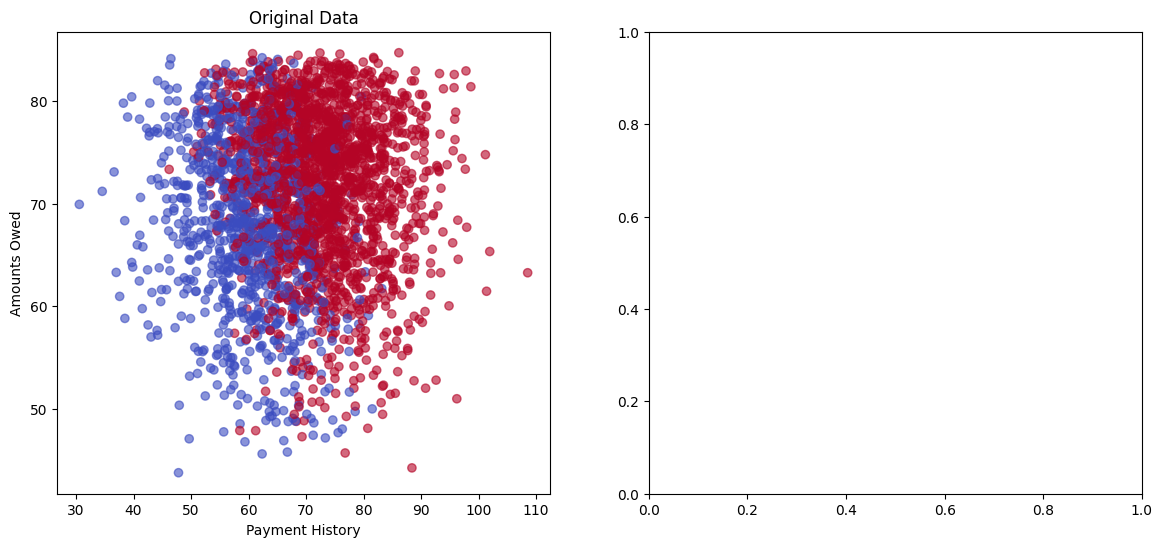

In [98]:
# Illustrating agents' movements in the feature space 2D
# For the first two features
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the original data
ax[0].scatter(X_test['Payment History'], X_test['Amounts Owed'], c=y_test, cmap='coolwarm', alpha=0.6)
ax[0].set_title("Original Data")
ax[0].set_xlabel("Payment History")
ax[0].set_ylabel("Amounts Owed")

# Plotting the manipulated data
ax[1].scatter(X_test['Payment History'], X_test['Amounts Owed'], c=optimized_predictions_perceived, cmap='coolwarm', alpha=0.6)
ax[1].set_title("Manipulated Data")
ax[1].set_xlabel("Payment History")
ax[1].set_ylabel("Amounts Owed")

plt.tight_layout()
plt.show()


## Multiple budgets

Number of agents closer than 1 to the decision boundary: 191


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Number of agents closer than 2 to the decision boundary: 352


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Number of agents closer than 3 to the decision boundary: 487


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Number of agents closer than 4 to the decision boundary: 609


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Number of agents closer than 5 to the decision boundary: 713


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Number of agents closer than 6 to the decision boundary: 792


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Number of agents closer than 7 to the decision boundary: 854


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Number of agents closer than 8 to the decision boundary: 902


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Number of agents closer than 9 to the decision boundary: 939


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Number of agents closer than 10 to the decision boundary: 969


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


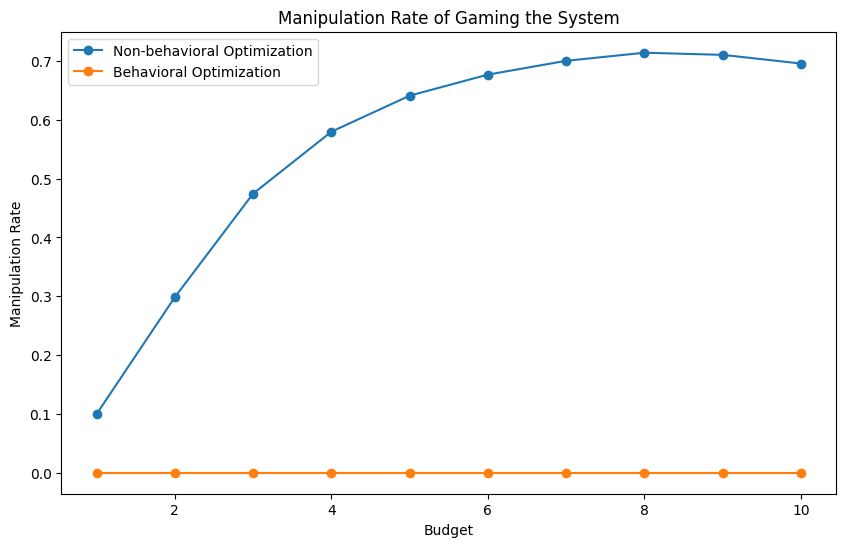

In [74]:
# do the same for multiple budgets
manipulation_rates_original = []
manipulation_rates_perceived = []

for b in budgets:
    # Choose agents closer than 'budget' to the dcision boundary
    mask = (np.abs(model.decision_function(X_test)) < b) & (initial_predictions == 0)
    print(f"Number of agents closer than {b} to the decision boundary: {np.sum(mask)}")
    X_to_optimize = X_test[mask]
    y_to_optimize = y_test[mask]

    # Optimization using original weights
    optimized_features_original = X_to_optimize.apply(optimize_features, axis=1, weights=model_weights, threshold=threshold)

    # Optimization using perceived weights
    optimized_features_perceived = X_to_optimize.apply(optimize_features, axis=1, weights=perceived_weights, threshold=threshold)

    # Predict with the optimized features (ndarray)
    optimized_features_original = np.array([np.array(xi) for xi in optimized_features_original])
    optimized_features_perceived = np.array([np.array(xi) for xi in optimized_features_perceived])
    
    # Predict with the optimized features
    optimized_predictions_original = model.predict(optimized_features_original)
    optimized_predictions_perceived = model.predict(optimized_features_perceived)

    # Calculate success rate
    manipulation_rate_original = np.mean(optimized_predictions_original == 1)
    manipulation_rates_original.append(manipulation_rate_original)

    manipulation_rate_perceived = np.mean(optimized_predictions_perceived == 1)
    manipulation_rates_perceived.append(manipulation_rate_perceived)

# Plotting the success rates
plt.figure(figsize=(10, 6))
plt.plot(budgets, manipulation_rates_original, marker='o', label='Non-behavioral Optimization')
plt.plot(budgets, manipulation_rates_perceived, marker='o', label='Behavioral Optimization')
plt.xlabel('Budget')
plt.ylabel('Manipulation Rate')
plt.title('Manipulation Rate of Gaming the System')
plt.legend()
plt.show()

## For multiple Gammas

In [92]:
# Find users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask]
y_to_optimize = y_test[mask]

# plot success rate for different gamma values
gammas = np.linspace(0, 1, 10)
manipulation_rates_p = []
manipulation_rates_o = []
firm_payoffs_p = []
firm_payoffs_o = []

# Optimization using original weights
optimized_features_original = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=model_weights, threshold=threshold)

# Predict with the optimized features (original weights)
optimized_predictions_original = model.predict(optimized_features_original)

# Calculate success rate (original weights)
manipulation_rate_o = np.mean(optimized_predictions_original == 1)

# Calculate firm payoff (original weights)
firm_payoff_o = np.sum((y_to_optimize == 1) & (optimized_predictions_original == 1)) - np.sum((y_to_optimize == 0) & (optimized_predictions_original == 1))

for g in gammas:
    manipulation_rate_p = 0
    firm_payoff_p = 0
    
    # Select users who are true negatives and predicted negatives
    mask = (y_test == 0) & (initial_predictions == 0)
    X_to_optimize = X_test[mask].copy()

    # Optimization using perceived weights
    optimized_features_perceived = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=behavioral(model_weights, g), threshold=threshold)
    
    # Predict with the optimized features (perceived weights)
    optimized_predictions_perceived = model.predict(optimized_features_perceived)

    # Calculate success rate (perceived weights)
    manipulation_rate_p += np.mean(optimized_predictions_perceived == 1)

    # Calculate firm payoff (perceived weights)
    firm_payoff_p = np.sum((y_to_optimize == 1) & (optimized_predictions_perceived == 1)) - np.sum((y_to_optimize == 0) & (optimized_predictions_perceived == 1))
    firm_payoffs_p.append(firm_payoff_p)

    manipulation_rates_p.append(manipulation_rate_p)

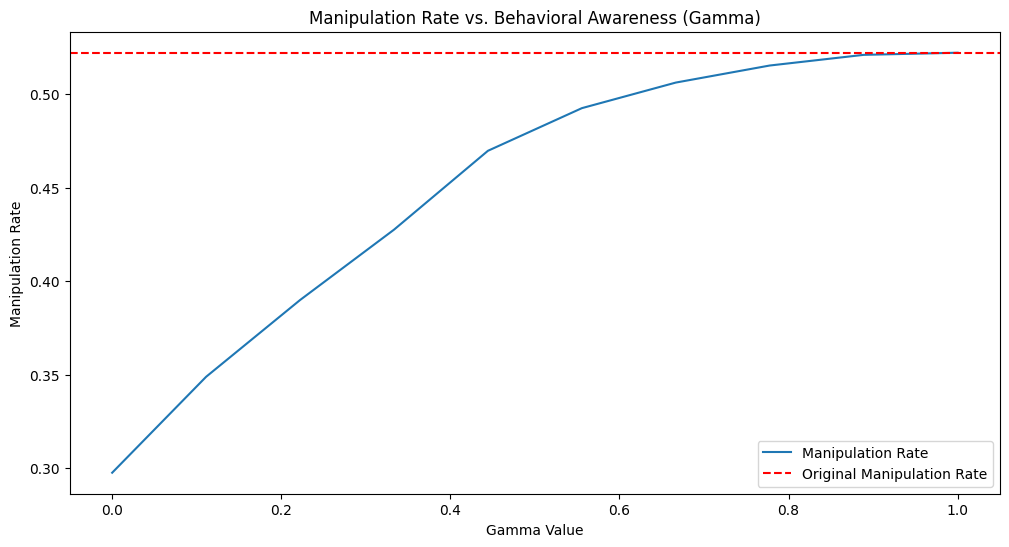

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(gammas, manipulation_rates_p, label='Manipulation Rate')
# plot original success rate
plt.axhline(y=manipulation_rate_o, color='r', linestyle='--', label='Original Manipulation Rate')
plt.xlabel('Gamma Value')
plt.ylabel('Manipulation Rate')
plt.title('Manipulation Rate vs. Behavioral Awareness (Gamma)')
plt.legend()
plt.show()

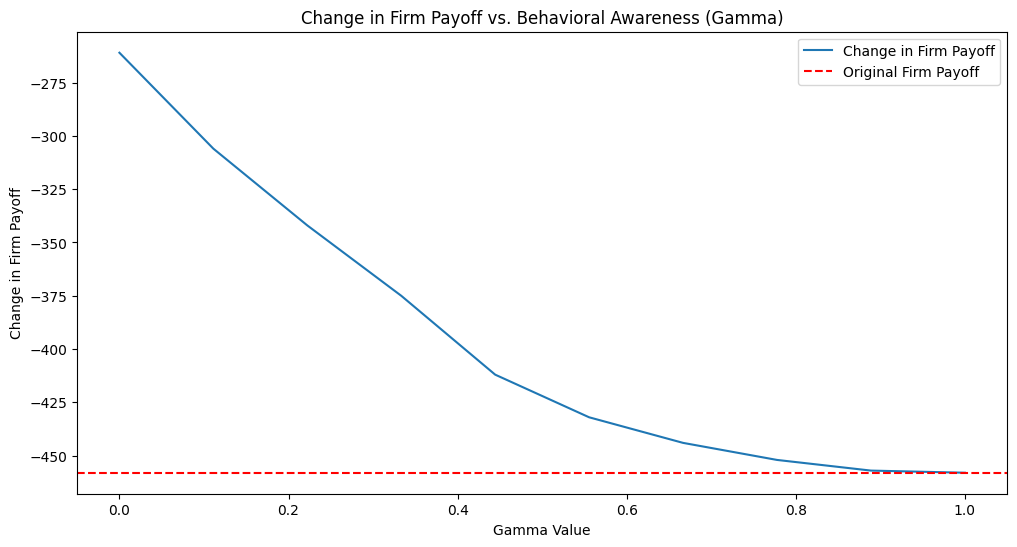

In [94]:
# Plot the firm payoff for different gamma values
plt.figure(figsize=(12, 6))
plt.plot(gammas, firm_payoffs_p, label='Change in Firm Payoff')
# plot original firm payoff
plt.axhline(y=firm_payoff_o, color='r', linestyle='--', label='Original Firm Payoff')
plt.xlabel('Gamma Value')
plt.ylabel('Change in Firm Payoff')
plt.title('Change in Firm Payoff vs. Behavioral Awareness (Gamma)')
plt.legend()

## Plotting for multiple individuals

Case 0:
Current Features: [96.37881752 68.40021812 42.6        64.2        61.89291704]


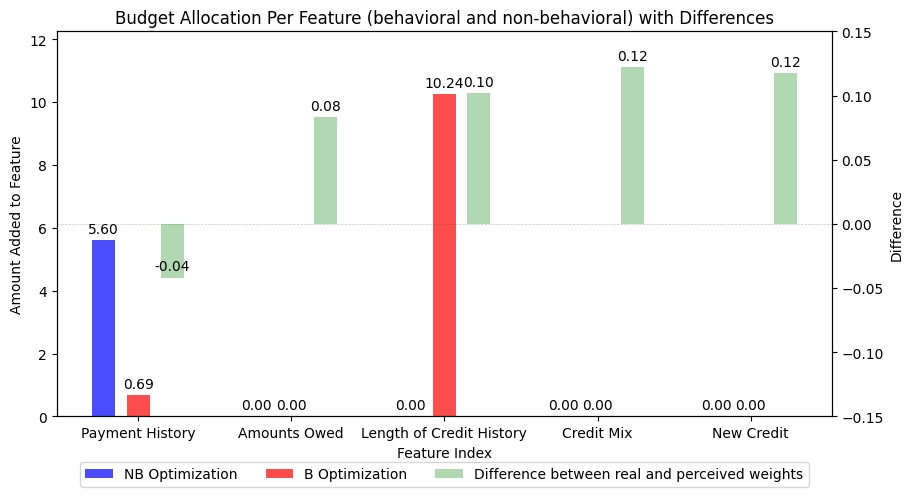

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 10:
Current Features: [87.55475698 80.5534388  75.7        70.6        49.56321858]


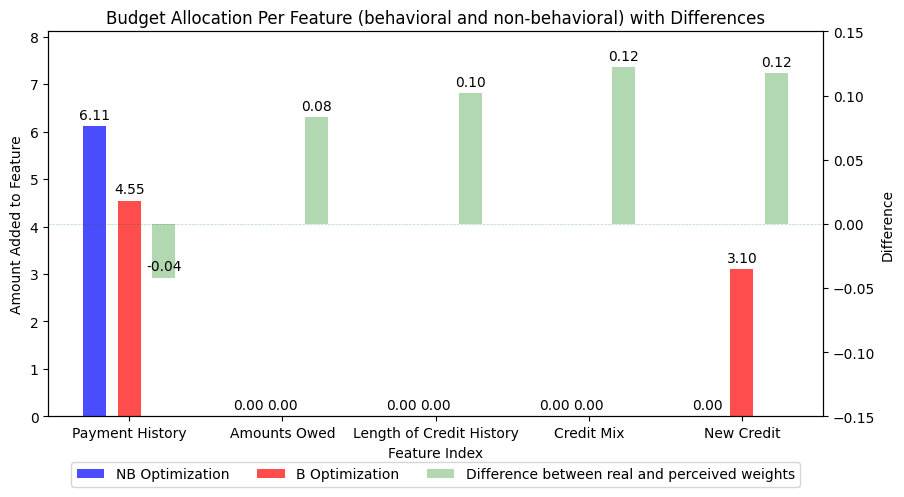

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 20:
Current Features: [65.56570582 66.47478254 79.         80.3        61.26013099]


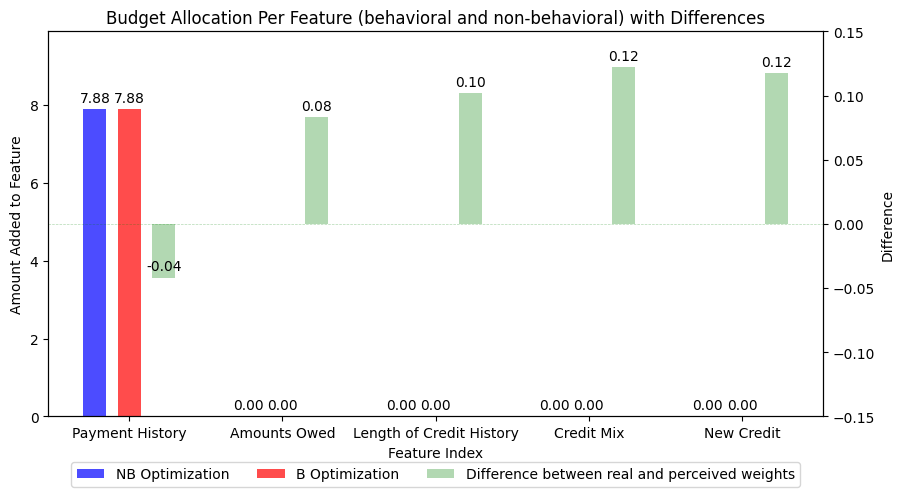

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 30:
Current Features: [75.95157025 79.64468503 48.1        83.3        41.64318347]


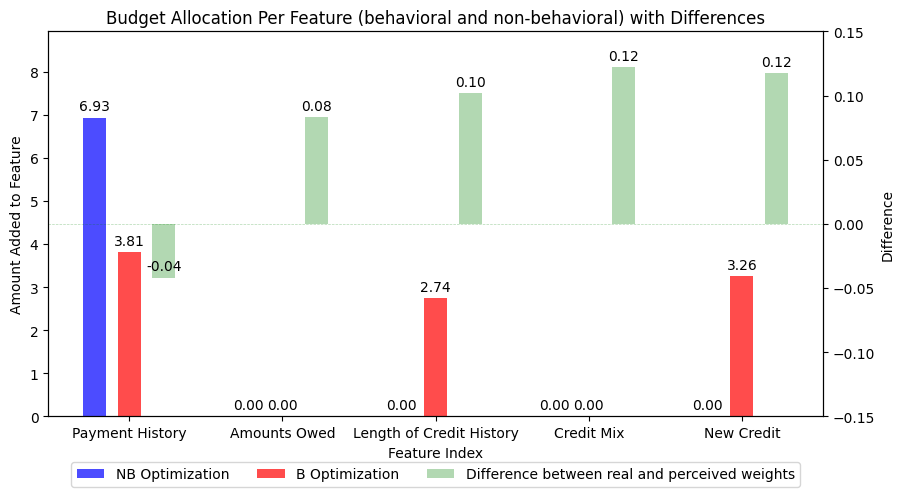

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 40:
Current Features: [74.68978078 57.21833377 49.6        78.         71.52280384]


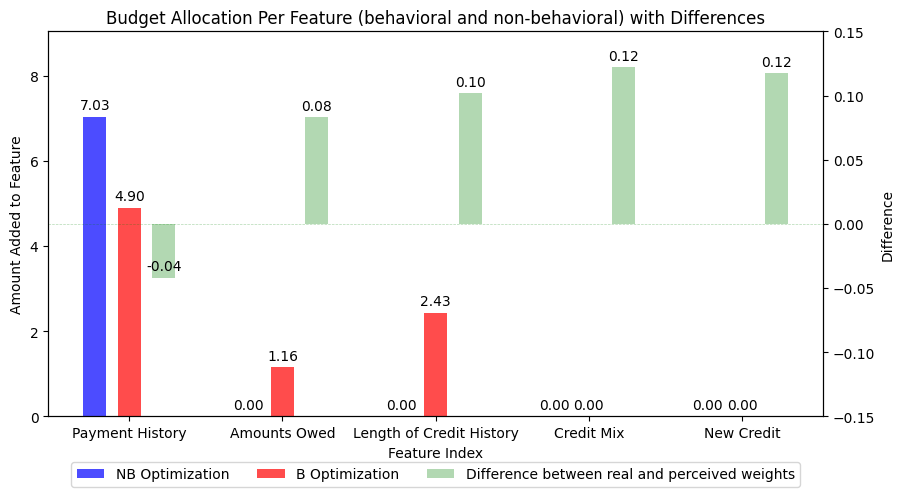

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 50:
Current Features: [52.13624535 73.95888108 61.         73.2        53.48963816]


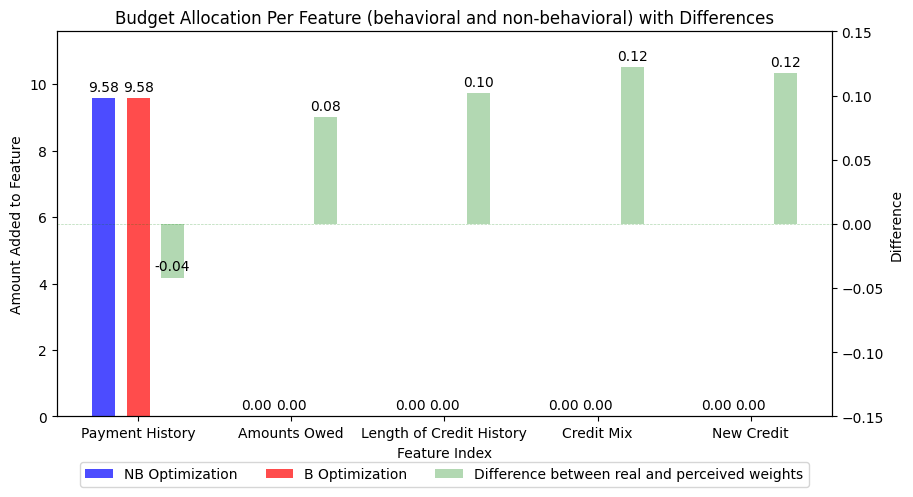

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 60:
Current Features: [75.50052099 83.57183643 43.7        63.7        77.9466601 ]


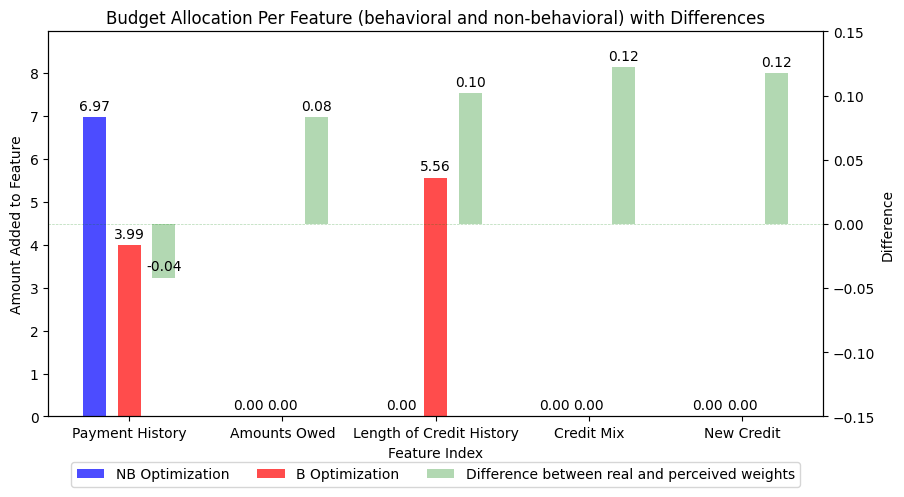

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 70:
Current Features: [67.1030304  71.25710165 68.1        73.2        65.05292185]


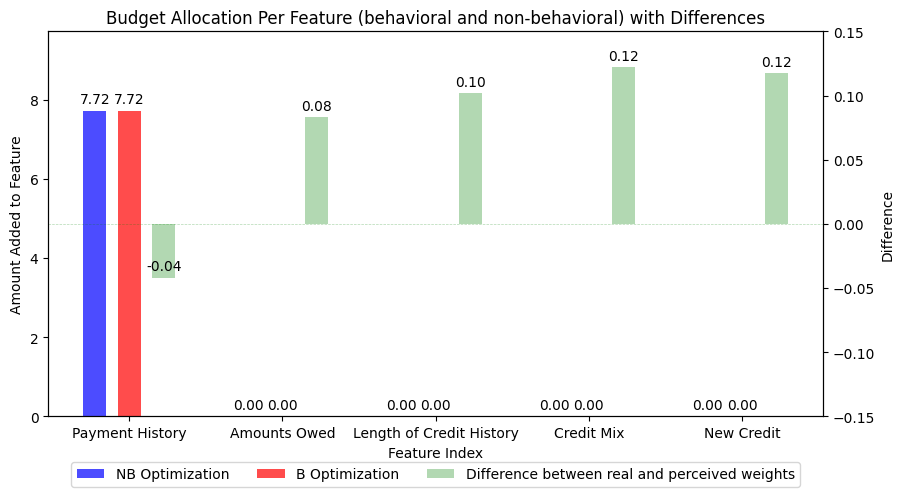

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 80:
Current Features: [52.55467111 78.93723761 78.3        72.2        51.57940246]


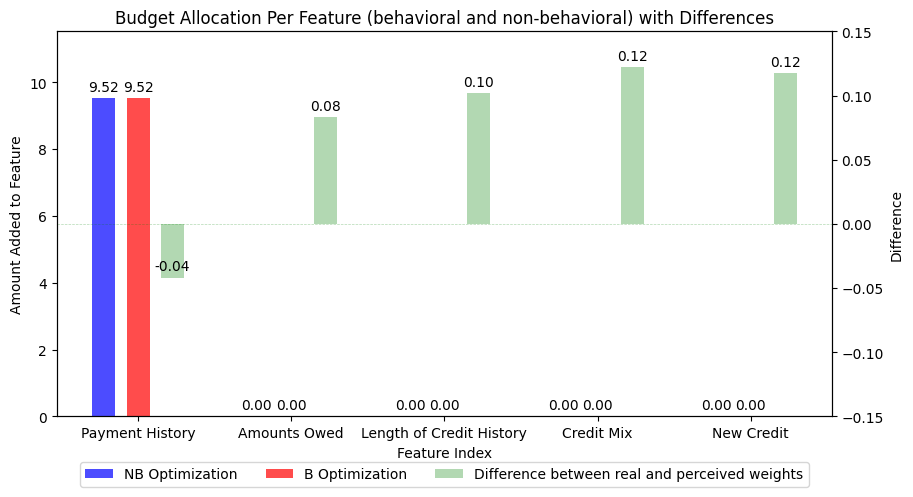

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 90:
Current Features: [49.86169499 62.61463696 68.         84.8        71.98550422]


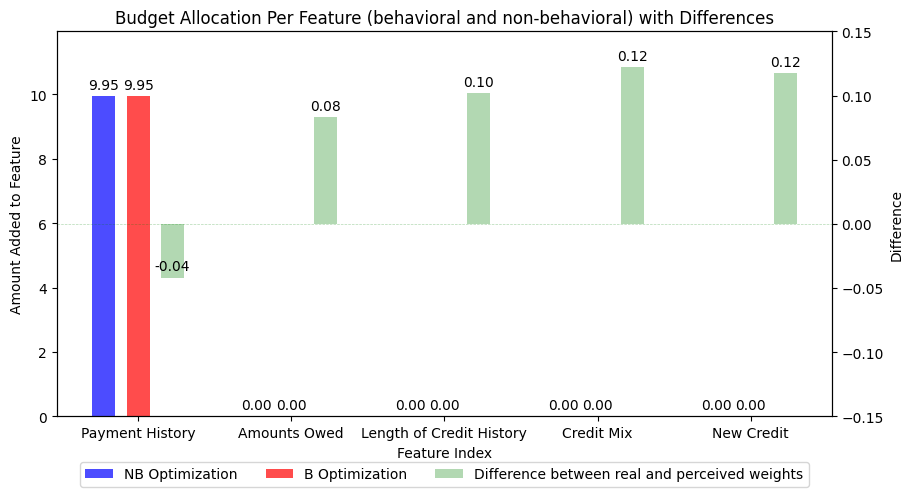

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 100:
Current Features: [81.49273326 49.98442669 33.4        82.6        45.17049377]


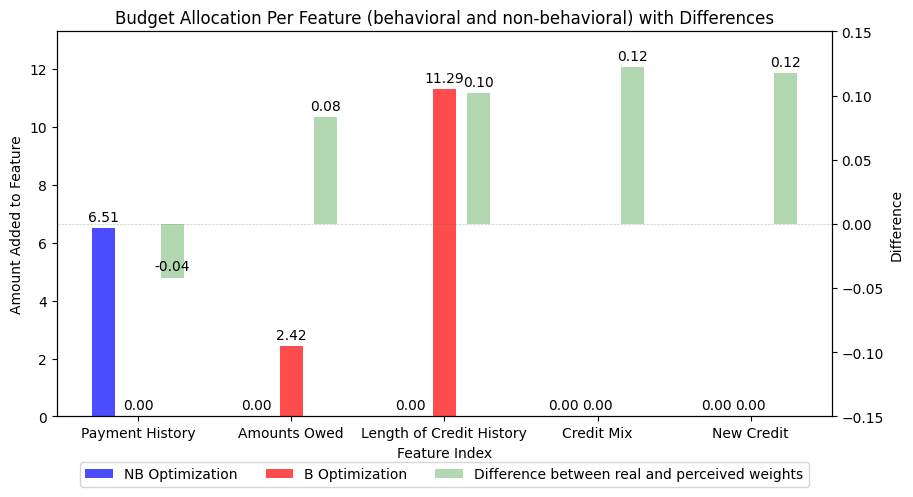

------------------------------------------------------------------------------------------------------------------------------------------------------




In [95]:
# Find users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask]
y_to_optimize = y_test[mask]

for case in cases:
    # Select a subset for demonstration (one row for simplicity)
    current_features = X_test.iloc[case].values
    print(f"Case {case}:")
    print(f"Current Features: {current_features}")

    # Optimize features
    optimized_features = optimize_features_log(current_features, budget, model_weights, threshold=threshold)
    # print(f"Optimized Features (Non-behavioral): {optimized_features}")
    # For behavioral optimization
    optimized_features_perceived = optimize_features_log(current_features, budget, weights=behavioral(model_weights, gamma), threshold=threshold)
    # print(f"Optimized Features (Behavioral): {optimized_features_perceived}")

    # Calculate the changes made to each feature
    changes_made = optimized_features - current_features
    changes_made_perceived = optimized_features_perceived - current_features

    # Assuming changes_made, changes_made_perceived, model_weights, and perceived_weights are defined
    differences = perceived_weights - model_weights
    df = pd.DataFrame({
        'Feature Index': list(range(len(changes_made))) * 3,  # Repeating for each type of data
        'Changes Made': list(changes_made) + list(changes_made_perceived) + list(differences),
        'Type': ['Real Weights']*len(changes_made) + ['Perceived Weights']*len(changes_made_perceived) + ['Difference']*len(differences),
        'Weight Labels': ['NB: {:.1f}'.format(w) for w in model_weights] + ['B: {:.1f}'.format(w) for w in perceived_weights] + ['Diff: {:.1f}'.format(d) for d in differences]
    })


    # Set up the plot
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Locations of the groups
    ind = np.arange(len(changes_made))  # the x locations for the groups
    width = 0.15  # the width of the bars

    # Plot bars for real and perceived weights on primary y-axis
    rects1 = ax1.bar(ind - 1.5*width, changes_made, width, label='NB Optimization', color='blue', alpha=0.7)
    rects2 = ax1.bar(ind, changes_made_perceived, width, label='B Optimization', color='red', alpha=0.7)

    # Create secondary y-axis
    ax2 = ax1.twinx()
    # Plot bars for differences on secondary y-axis
    rects3 = ax2.bar(ind + 1.5*width, differences, width, label='Difference between real and perceived weights', color='green', alpha=0.3)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax1.set_xlabel('Feature Index')
    ax1.set_ylabel('Amount Added to Feature')
    ax2.set_ylabel('Difference')
    ax1.set_title('Budget Allocation Per Feature (behavioral and non-behavioral) with Differences')
    ax1.set_xticks(ind)
    # feature names as x-axis labels
    ax1.set_xticklabels(['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit'])

    # set the y-axis limits
    # find max value for y-axis
    max_y = max(max(changes_made), max(changes_made_perceived))
    ax1.set_ylim(0, max_y + 2)
    ax2.set_ylim(-0.15, 0.15)
    # horizontal line for 0 difference
    ax2.axhline(0, color='green', linewidth=0.5, linestyle='--', alpha=0.3)

    # Combine legends from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

    # Attach a text label above each bar in rects1 and rects2, displaying height.
    def autolabel(rects, axis):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            axis.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1, ax1)
    autolabel(rects2, ax1)
    autolabel(rects3, ax2)

    plt.show()

    print('-'*150)
    print('\n')


# Closing the loop --> The firm finds optimal weights

In [96]:
# Generate the dataset (original)
df_2 = generate_synthetic_fico_data()
fico_df_2 = df_2.copy()

# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.1 * (x - 650)))

# Calculate the approval probability for each individual
fico_df_2['Approval Probability'] = sigmoid(fico_df_2['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df_2['True Label'] = (fico_df_2['Approval Probability'] > np.random.rand(fico_df_2.shape[0])).astype(int)

# Drop the FICO Score and Approval Probability columns
fico_df_2.drop(['FICO Score', 'Approval Probability'], axis=1, inplace=True)

# Example dataset loading
# Assuming 'FICO Score' is not used as a feature directly in the model training
X = fico_df_2[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']]  # model features
y = fico_df_2['True Label']  # the target variable

### Non-behavioral

In [155]:
from tqdm import tqdm

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# Initialize weights
weights_0 = model.coef_[0]
intercept_0 = model.intercept_[0]
print(f"Initial Weights: {weights_0}")
print(f"Initial Intercept: {intercept_0}")

# Store a copy of the original training set
X_train_original = X_train.copy()
y_train_original = y_train.copy()

# Define optimization parameters
max_iterations = 5
tolerance = 1e-3

new_weights = weights_0

# Loop with progress bar
for _ in tqdm(range(max_iterations), desc="Iterations", unit="iter"):
    X_train = X_train_original.copy()
    y_train = y_train_original.copy()
    
    # Find the rows to do optimization
    mask_train = (y_train == 0) & (model.predict(X_train) == 0)
    X_to_optimize_train = X_train[mask_train].copy()

    # Simulate feature manipulation
    X_train_optimized = X_to_optimize_train.apply(optimize_features_log, axis=1, budget=budget, weights=weights_0, threshold=threshold)

    # update X_train with the optimized features
    X_train[mask_train] = X_train_optimized

    # Fit the model with the optimized features
    model.fit(X_train, y_train)
    new_weights = model.coef_[0]
    
    print(f"Weights for iteration {_ + 1}: {new_weights}")

    # Check for convergence
    if np.linalg.norm(new_weights - weights_0) < tolerance or _ == max_iterations - 1:
        # Final weights to announce and the intercept
        announced_weights_nb = new_weights
        intercept_nb = model.intercept_[0]
        break

Initial Weights: [0.45204536 0.19512799 0.15056732 0.08887422 0.10552186]
Initial Intercept: -64.39448501152475


Iterations:   0%|          | 0/5 [00:00<?, ?iter/s]/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Iterations:  20%|██        | 1/5 [00:07<00:31,  7.99s/iter]

Weights for iteration 1: [0.25595162 0.12901783 0.10322556 0.05938286 0.07131255]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Iterations:  40%|████      | 2/5 [00:16<00:25,  8.52s/iter]

Weights for iteration 2: [0.21131097 0.11610607 0.09232163 0.05393434 0.06387143]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Iterations:  60%|██████    | 3/5 [00:25<00:17,  8.55s/iter]

Weights for iteration 3: [0.21547894 0.11855904 0.09428943 0.0548543  0.06504808]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Iterations:  80%|████████  | 4/5 [00:34<00:08,  8.56s/iter]

Weights for iteration 4: [0.21521772 0.11843243 0.09423598 0.05479541 0.06496914]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Iterations:  80%|████████  | 4/5 [00:42<00:10, 10.62s/iter]

Weights for iteration 5: [0.21495499 0.11828856 0.09418484 0.054716   0.06490672]


### Behavioral

In [156]:
from tqdm import tqdm

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

# Initialize weights
weights_0 = model.coef_[0]
intercept_0 = model.intercept_[0]
print(f"Initial Weights: {weights_0}")
print(f"Initial Intercept: {intercept_0}")

# Store a copy of the original training set
X_train_original = X_train.copy()
y_train_original = y_train.copy()

# Define optimization parameters
max_iterations = 5
tolerance = 1e-3

new_weights = weights_0

# Loop with progress bar
for _ in tqdm(range(max_iterations), desc="Iterations", unit="iter"):
    X_train = X_train_original.copy()
    y_train = y_train_original.copy()
    
    # Find the rows to do optimization
    mask_train = (y_train == 0) & (model.predict(X_train) == 0)
    X_to_optimize_train = X_train[mask_train].copy()

    # Simulate feature manipulation
    X_train_optimized = X_to_optimize_train.apply(optimize_features_log, axis=1, budget=budget, weights=behavioral(model_weights, gamma), threshold=threshold)

    # update X_train with the optimized features
    X_train[mask_train] = X_train_optimized

    # Fit the model with the optimized features
    model.fit(X_train, y_train)
    new_weights = model.coef_[0]
    
    print(f"Weights for iteration {_ + 1}: {new_weights}")

    # Check for convergence
    if np.linalg.norm(new_weights - weights_0) < tolerance or _ == max_iterations - 1:
        # Final weights to announce and the intercept
        announced_weights_b = new_weights
        intercept_b = model.intercept_[0]
        break

Initial Weights: [0.45204536 0.19512799 0.15056732 0.08887422 0.10552186]
Initial Intercept: -64.39448501152475


Iterations:  20%|██        | 1/5 [00:07<00:31,  7.83s/iter]

Weights for iteration 1: [0.31712131 0.13744099 0.09625369 0.06620707 0.07252007]


Iterations:  40%|████      | 2/5 [00:16<00:24,  8.26s/iter]

Weights for iteration 2: [0.26991163 0.12076126 0.08129377 0.05924415 0.06293065]


Iterations:  60%|██████    | 3/5 [00:24<00:16,  8.38s/iter]

Weights for iteration 3: [0.2687599  0.12047207 0.08095625 0.05939858 0.06279597]


Iterations:  80%|████████  | 4/5 [00:33<00:08,  8.47s/iter]

Weights for iteration 4: [0.2687599  0.12047207 0.08095625 0.05939858 0.06279597]


Iterations:  80%|████████  | 4/5 [00:42<00:10, 10.52s/iter]

Weights for iteration 5: [0.2687599  0.12047207 0.08095625 0.05939858 0.06279597]


In [ ]:
class LogisticRegressionModel:
    def __init__(self, weights, intercept):
        self.weights = weights
        self.intercept = intercept
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def predict_proba(self, X):
        linear_output = np.dot(X, self.weights) + self.intercept
        return self.sigmoid(linear_output)
    
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        predictions = np.where(probabilities >= threshold, 1, 0)
        return predictions

In [157]:
model_og = LogisticRegressionModel(weights_0, intercept_0)
model_nb = LogisticRegressionModel(announced_weights_nb, intercept_nb)
model_b = LogisticRegressionModel(announced_weights_b, intercept_b)

In [158]:
print(f"\nAnnounced Weights: {announced_weights_nb}")
print(f"Announced Intercept: {intercept_nb}")
print(f"Announced Weights (Behavioral): {announced_weights_b}")
print(f"Announced Intercept (Behavioral): {intercept_b}")
print(f"Original Weights: {weights_0}")
print(f"Original Intercept: {intercept_0}")


Announced Weights: [0.21495499 0.11828856 0.09418484 0.054716   0.06490672]
Announced Intercept: -36.066515855979986
Announced Weights (Behavioral): [0.2687599  0.12047207 0.08095625 0.05939858 0.06279597]
Announced Intercept (Behavioral): -39.25752741905961
Original Weights: [0.45204536 0.19512799 0.15056732 0.08887422 0.10552186]
Original Intercept: -64.39448501152475


In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Select users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask].copy()

# Optimization using original weights
optimized_features_original = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=weights_0, threshold=threshold)
# Predict with the optimized features
optimized_predictions_original = model_og.predict(optimized_features_original)
# Calculate success rate
success_rate_original = np.mean(optimized_predictions_original == 1)
print(f"Manipulation rate of gaming the system with original weights: {success_rate_original:.2%}")

# print('-'*150)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Select users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask].copy()

# Optimization using announced weights
optimized_features_announced_nb = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=announced_weights_nb, threshold=threshold)
# Predict with the optimized features
optimized_predictions_announced_nb = model_nb.predict(optimized_features_announced_nb)
# Calculate success rate
success_rate_announced_nb = np.mean(optimized_predictions_announced_nb == 1)
print(f"Manipulation rate of gaming the system with optimal weights: {success_rate_announced_nb:.2%}")

# print('-'*150)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Select users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask].copy()

# Optimization using announced weights
optimized_features_announced_b = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=announced_weights_b, threshold=threshold)
# Predict with the optimized features
optimized_predictions_announced_b = model_b.predict(optimized_features_announced_b)
# Calculate success rate
success_rate_announced_b = np.mean(optimized_predictions_announced_b == 1)
print(f"Manipulation rate of gaming the system with optimal weights (Behavioral): {success_rate_announced_b:.2%}")

Manipulation rate of gaming the system with original weights: 52.22%
Manipulation rate of gaming the system with optimal weights: 31.13%
Manipulation rate of gaming the system with optimal weights (Behavioral): 36.94%


## Forcing sum to be one

In [30]:
def sigmoid_new(z):
    return 1 / (1 + cp.exp(-z))

def model_fit(X_train, y_train):
    # Weights and intercept as cvxpy variables
    n_features = X_train.shape[1]
    weights = cp.Variable(n_features)
    intercept = cp.Variable()
    
    # Logistic regression loss function using cvxpy operations
    z = X_train @ weights + intercept
    log_likelihood = cp.sum(cp.multiply(y_train, cp.log(sigmoid_new(z))) + cp.multiply((1 - y_train), cp.log(sigmoid_new(-z))))
    
    # Objective function to maximize the log-likelihood
    objective = cp.Maximize(log_likelihood)
    
    # Constraints: sum of weights equals one (excluding intercept)
    constraints = [cp.sum(weights) == 1]
    
    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    # Get the optimized weights and intercept
    optimized_weights = weights.value
    optimized_intercept = intercept.value
    
    return optimized_weights, optimized_intercept

# Prediction function
def predict(X, weights, intercept):
    z = X @ weights + intercept
    return (sigmoid_new(z).value >= 0.5).astype(int)

In [31]:
from tqdm import tqdm

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Initialize weights
weights, intercept = model_fit(X_train, y_train)

# Store a copy of the original training set
X_train_original = X_train.copy()
y_train_original = y_train.copy()

# Define optimization parameters
max_iterations = 100
tolerance = 1e-5

new_weights = weights
new_intercept = intercept

# Loop with progress bar
for _ in tqdm(range(max_iterations), desc="Iterations", unit="iter"):
    X_train = X_train_original.copy()
    y_train = y_train_original.copy()
    
    # Find the rows to do optimization
    mask_train = (y_train == 0) & (predict(X_train, new_weights, new_intercept) == 0)
    X_to_optimize_train = X_train[mask_train].copy()

    # Simulate feature manipulation
    X_train_optimized = X_to_optimize_train.apply(optimize_features_log, axis=1, budget=budget, weights=behavioral(model_weights, g), threshold=threshold)

    # update X_train with the optimized features
    X_train[mask_train] = X_train_optimized

    # Fit the model with the optimized features
    new_weights, new_intercept = model_fit(X_train, y_train)
    
    print(f"New Weights for iteration {_ + 1}: {new_weights}")

    # Check for convergence
    if np.linalg.norm(new_weights - weights) < tolerance:
        # Final weights to announce
        announced_weights = new_weights
        break

# announced weights and the original weights
print("Original Weights:")
for feature, coef in zip(feature_names, weights):
    print(f"{feature}: {coef:.4f}")

print("\nAnnounced Weights:")
for feature, coef in zip(feature_names, announced_weights):
    print(f"{feature}: {coef:.4f}")


# Select users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask].copy()

# Optimization using original weights
optimized_features_original = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=weights, threshold=threshold)

# Optimization using announced weights
optimized_features_announced = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=announced_weights, threshold=threshold)

# Predict with the optimized features
optimized_predictions_original = model.predict(optimized_features_original)
optimized_predictions_announced = model.predict(optimized_features_announced)

# Calculate success rate
success_rate_original = np.mean(optimized_predictions_original == 1)
print(f"Manipulation rate of gaming the system with original weights: {success_rate_original:.2%}")

success_rate_announced = np.mean(optimized_predictions_announced == 1)
print(f"Manipulation rate of gaming the system with optimal weights: {success_rate_announced:.2%}")

IndexError: tuple index out of range